# セグメンテーションのチュートリアル

実行環境(最新版をインストールしておけば大丈夫だと思います)
- Python : 3.10.12 (pyenv)
- torch : 2.0.1+cu118
- torchvision : 0.15.2+cu118
- matplotlib : 3.7.2
- Opencv-python : 4.8.0.74
- alubmentations : 1.4.11
- segmentation_models_pytorch : 0.3.3

# 🔍セグメンテーションとは
セグメンテーションとは、画像を複数の意味のある領域に分ける技術です。  
セグメンテーションにはいくつかの種類がありますが、このノートブックでは**セマンティックセグメンテーション**を扱います。  

セマンティックセグメンテーションとは、画像のすべてのピクセルに対して「これは何か？」というラベルを割り当てる手法です。  

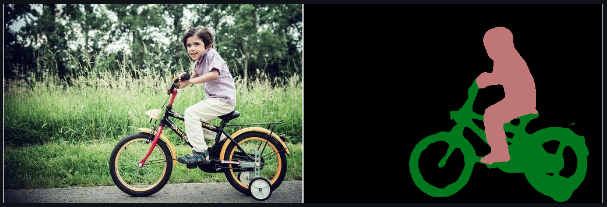

(画像元)https://github.com/tensorflow/models/tree/master/research/deeplab

このノートブックでは、以下のような脳腫瘍のMRI画像を使って、セマンティックセグメンテーションを体験します。

クラス 0（黒）：正常な領域（腫瘍以外のピクセル）

クラス 1（白）：腫瘍に該当するピクセル

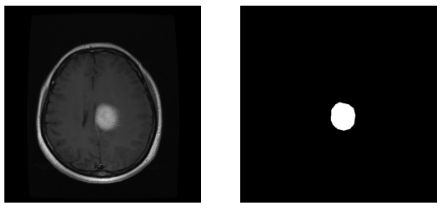

# 📦モジュールのインポート

モデルの学習や画像の読み込みなどに使用するモジュールをインポートします。

In [3]:
import os, random
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from tqdm import tqdm
import time

# 🎲 乱数シードを固定する

機械学習では、データのシャッフルや重みの初期化などに乱数が使われるため、  
毎回の実行で結果が少しずつ変わることがあります。

そこで、乱数の種（シード）を固定することで、実行ごとに同じ結果が得られるようにします。  
これを「再現性の確保」と呼びます。

以下のセルでは、Python・NumPy・PyTorch それぞれの乱数生成に対して同じシード値（今回は 42）を設定しています。

In [4]:
# seedの固定
def seed_everything(seed : int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(42)

# 🖼️ 画像の準備  
セグメンテーションの学習や検証を行うためには、画像とマスク画像のペアが必要です。  
今回は、脳腫瘍のデータセットを利用します。以下のURLからデータセットをダウンロードしてください。  
🔗 https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

ダウンロードしたzipファイルを展開すると、imagesフォルダとmasksフォルダが生成されます。  
それぞれのフォルダには、1から3064までの数字を名前に持つ画像ファイルが含まれています。  
同じ名前のファイルは、画像とマスク画像として対応しています（例：images/1.png と masks/1.png）。  

このノートブック（ipynbファイル）と同じ場所にdataフォルダを作成し、その中にimagesフォルダとmasksフォルダを配置してください。  

以下のような構成になっていればOKです。  

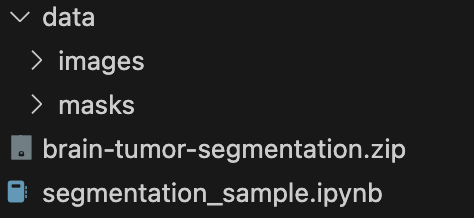

# 🖼️ 画像データを表示してみる
まずは、データセットに含まれている画像とマスク画像がどのようなものかを確認してみます。  

1. 画像が配置されているディレクトリのパス（場所）を指定する

    imagesフォルダとmasksフォルダには、それぞれ3064枚の画像とマスク画像が用意されています。  
    今回は、その中から1番目と2番目の画像とマスク画像のペアを表示してみます。

In [4]:
# imagesフォルダとmasksフォルダを指定
images_dir = './data/images'
masks_dir = './data/masks'

2. imagesフォルダとmasksフォルダ内にある画像のパスを取得する

    ここでは、globモジュール を使うことで、フォルダ内にあるすべての画像のパスを一括で取得することができます。

    　📌 globモジュールの使い方： glob.glob(フォルダ名 + ' / * ')  
    　「*」 は「ワイルドカード」と呼ばれ、任意の文字列にマッチします。詳しくは検索して調べてみてください。

    さらに、取得したパスの数を len関数 を使って表示することで、画像の枚数を確認することができます。

    　📌 len関数の使い方： len(オブジェクト)  
    　たとえば、リストの要素数を知りたいときに使います。

In [5]:
# 各フォルダ下の画像のパスを取得
image_files = sorted(glob.glob(images_dir + '/*.png'))
mask_files = sorted(glob.glob(masks_dir + '/*.png'))

# 各フォルダ内の画像の枚数を確認
print('Number of images:', len(image_files), "枚")
print('Number of masks :', len(mask_files), "枚")
print()

# 実際の画像のパスを確認
print(image_files[:10]) # 最初の10枚

Number of images: 3064 枚
Number of masks : 3064 枚

['./data/images/1.png', './data/images/10.png', './data/images/100.png', './data/images/1000.png', './data/images/1001.png', './data/images/1002.png', './data/images/1003.png', './data/images/1004.png', './data/images/1005.png', './data/images/1006.png']


3. 画像を表示する

    2.で取得した画像のパスを使い、PillowのImageクラスを用いて画像を読み込みます。  
    その後、matplotlib を使って画像を表示してみましょう。

    画像の読み込み方法には、主に以下の2通りがあります。
    
    - Pillowを用いた方法  
    `img = Image.open(path)`
    
    - OpenCVを用いた方法  
    `img = cv2.imread(path)`

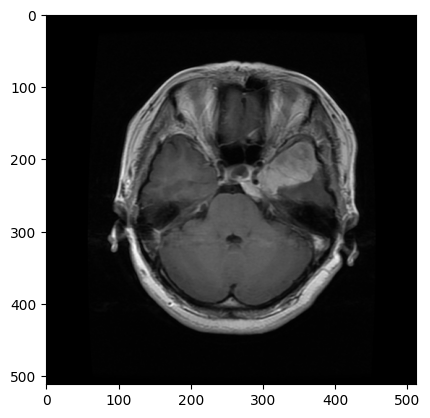

In [6]:
# 画像を読み込む
img = Image.open(image_files[0]) # imagesフォルダの最初の画像を読み込む
# 画像を表示
plt.imshow(img, cmap='gray')
plt.show()

以下のように、subplot を用いることで複数の画像をまとめて表示することもできます。  
（ここはざっと見るだけで大丈夫です！）

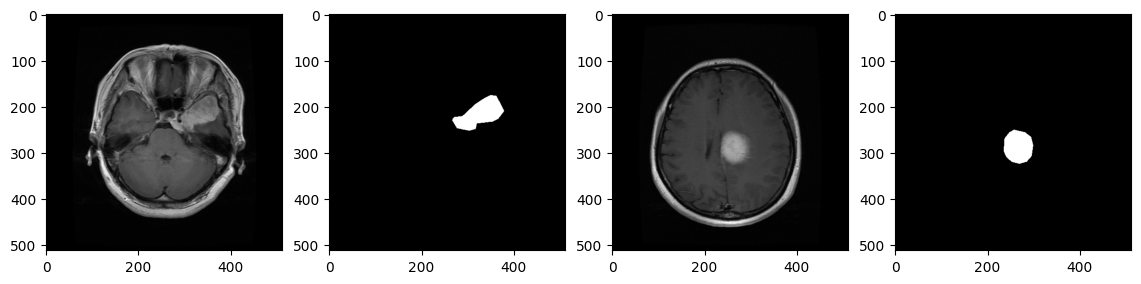

In [7]:
# 複数枚の画像をまとめて表示
plt.figure(figsize=(14, 5))
plt.subplot(1,4,1) # 1行4列の1番目の位置
plt.imshow(Image.open(image_files[0]), cmap='gray')
plt.subplot(1,4,2) # 1行4列の2番目の位置
plt.imshow(Image.open(mask_files[0]), cmap='gray')
plt.subplot(1,4,3) # 1行4列の3番目の位置
plt.imshow(Image.open(image_files[1]), cmap='gray')
plt.subplot(1,4,4) # 1行4列の3番目の位置
plt.imshow(Image.open(mask_files[1]), cmap='gray')
plt.show()

# 📂 データを分割する


imagesフォルダとmasksフォルダの中には、それぞれ3064枚の画像が含まれています。
これらの画像を、学習用（train）データ・検証用（valid）データ・テスト用（test）データの3つに分割します。

それぞれの用途は以下のとおりです：

- 学習用データ  
　モデルを訓練（学習）するために使用します。

- 検証用データ  
　学習中にモデルの性能を確認しながら、ハイパーパラメータ（学習率やエポック数など）を調整するために使用します。

- テスト用データ  
　最終的に学習が完了したモデルの精度を評価するために使用します。

このようにデータを分けることで、特定のデータに対してモデルが過剰に適応してしまう「[過学習](https://www.nri.com/jp/knowledge/glossary/lst/ka/overfitting)」を防ぐことができます。

## 🧮具体的な分割方法

一般的に、学習用データ・検証用データ・テスト用データは「8:1:1」の割合で分割されることが多いです。  
そのため、今回は3064枚の画像を次のように分けます：

- 学習用：2452枚

- 検証用：306枚

- テスト用：306枚

分割したデータは、pandasモジュールを使ってCSVファイル（Excelファイルに似た表形式のファイル）として保存し、  
学習・検証・テスト用データをそれぞれ整理して管理します。

以下のセルでは、画像のパスが格納された image_files を「8:1:1（2452枚：306枚：306枚）」の割合で分割しています。

具体的には、image_files のインデックスに基づいて、以下のように分けています：

先頭（インデックス 0 〜 2451） の2452枚を train_image_files（学習用）とします。

次の306枚（インデックス 2452 〜 2757） を val_image_files（検証用）とします。

残り（インデックス 2758 〜 最後） を test_image_files（テスト用）とします。

また、mask_files に対しても、image_files と同様のインデックスを用いて同じように分割しています。

In [8]:
train_image_files = image_files[0:2452]
val_image_files = image_files[2452:2452+306]
test_image_files = image_files[2452+306:]

train_mask_files = mask_files[:2452]
val_mask_files = mask_files[2452:2452+306]
test_mask_files = mask_files[2452+306:]

print('Number of train images:', len(train_image_files), "枚")
print('Number of val images:', len(val_image_files), "枚")
print('Number of test images:', len(test_image_files), "枚")


Number of train images: 2452 枚
Number of val images: 306 枚
Number of test images: 306 枚


## 📋 データフレームの作成

以下のセルでは、学習用・検証用・テスト用のそれぞれに対してデータフレームを作成しています。  
ここでは、pandasモジュールを用いてデータフレームを作成します。  


📌 pandas.DataFrame の基本的な使い方：

1.  データフレームを作成する  
　`df = pandas.DataFrame(columns=["カラム1", "カラム2"])`

2. データを入力する  
　
    - セルに直接データを入力する場合： `df.loc[0, "カラム1"] = 1`   
    - 特定のカラムにまとめてデータを入力する場合： `df["カラム1"] = [1,2,3,4]`

今回は、カラム名が "image" と "mask" のデータフレームを作成し、  
画像のパスとマスク画像のパスをそれぞれ対応させて入力します。

（作成されるデータフレームのイメージは以下のとおりです。）

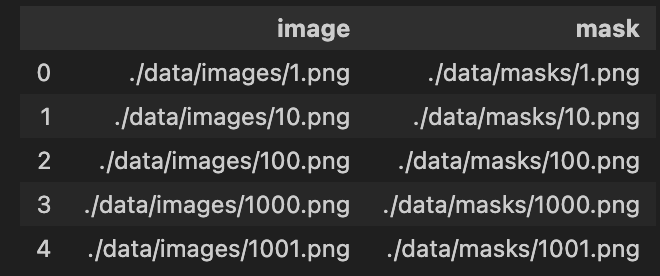

In [9]:
df = pd.DataFrame(columns=["A", "B"])
df.head()

,A,B


In [10]:
df.loc[0, "A"] = 1

In [11]:
df.head()

,A,B
0,1,NaN


In [12]:
# 学習用データのDataFrameを作成
train_df = pd.DataFrame(columns=["image", "mask"])
# 検証用データのDataFrameを作成
val_df = pd.DataFrame(columns=["image", "mask"])
# テスト用データのDataFrameを作成
test_df = pd.DataFrame(columns=["image", "mask"])

# 設定したカラムを表示してみる(値を入力していないため，枠組みだけ)
train_df.head()

,image,mask


作成した train_df、val_df、test_df に、  
分割した画像のパス（train_image_files など）とマスク画像のパス（train_mask_files など）を入力します。

これにより、各データフレームには対応する画像とマスク画像のペア情報が格納されます。

In [13]:
# 学習用データのDataFrameに画像とマスクのパスを追加
train_df["image"] = train_image_files
train_df["mask"] = train_mask_files

# 検証用データのDataFrameに画像とマスクのパスを追加
val_df["image"] = val_image_files
val_df["mask"] = val_mask_files

# テスト用データのDataFrameに画像とマスクのパスを追加
test_df["image"] = test_image_files
test_df["mask"] = test_mask_files

# 作成したDataFrameの形状を確認
print("train_df.shape:", train_df.shape) # (2452, 2) : 2452枚の画像とマスク画像のパスが格納されている
print("val_df.shape  :", val_df.shape)   # (306, 2)  : 306枚の画像とマスク画像のパスが格納されている
print("test_df.shape :", test_df.shape)  # (306, 2)  : 306枚の画像とマスク画像のパスが格納されている

# 入力した結果を表示してみる(先頭5行)
train_df.head()

train_df.shape: (2452, 2)
val_df.shape  : (306, 2)
test_df.shape : (306, 2)


,image,mask
0,./data/images/1.png,./data/masks/1.png
1,./data/images/10.png,./data/masks/10.png
2,./data/images/100.png,./data/masks/100.png
3,./data/images/1000.png,./data/masks/1000.png
4,./data/images/1001.png,./data/masks/1001.png


## 💾CSVファイルの保存と読み込み

dataフォルダの下に、作成した train_df、val_df、test_df をCSVファイルとして保存します。  
保存しておくことで、次回以降の読み込みが簡単になります。

以下のような構成になっていればOKです：


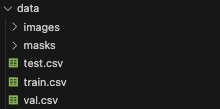

In [14]:
# CSVファイルに保存
train_df.to_csv("./data/train.csv", index=False)
val_df.to_csv("./data/val.csv", index=False)
test_df.to_csv("./data/test.csv", index=False)

In [15]:
# CSVファイルを読み込む
train_df = pd.read_csv("./data/train.csv")
val_df = pd.read_csv("./data/val.csv")
test_df = pd.read_csv("./data/test.csv")

# 📦DatasetとDataloaderの作成

モデルを学習させる際には、データを小さなグループ（ミニバッチ）に分けて処理する
ミニバッチ学習という手法がよく用いられます。
このとき、1回の学習に使用するデータの個数はバッチサイズ（batch_size）と呼ばれます。

ミニバッチごとにデータを取り出す際に使用するのが、Dataset と DataLoader です。
それぞれの役割は以下のとおりです。

## 🗂️ Dataset
Dataset は、データソース（CSVや画像ファイルなど）からデータを1件ずつ読み込み、必要な前処理（transform）を行うクラスです。
今回は、自作の Dataset クラスを定義して使用します。

たとえば、以下のようにして学習用データセット（train_dataset）を作成します：

```Python
# train_datasetの作成例
train_dataset = MyDataset(df = train_df, transforms = transforms)
```

## 🔁 DataLoader
DataLoader は、Dataset からデータを取り出し、指定されたバッチサイズごとにまとめて順次取り出すための仕組みです。

DataLoader には、shuffle という引数があります。

shuffle=True にすると、毎回ランダムな順番でデータが読み込まれます（→学習時に使用）

shuffle=False にすると、常に同じ順番でデータが読み込まれます（→検証・テスト時に使用）

たとえば、以下のようにして学習用データローダ（train_loader）を作成します：

```Python
# train_loaderの作成例
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
```

## 🔧 前処理 （transform）
前処理（transform）は、通常、学習用と検証・テスト用で異なる設定を行います。

- 学習用  
　ランダムな回転や反転などのデータ拡張を加えることで、データのバリエーションを増やし、モデルの汎化性能を高めます。

- 検証用・テスト用  
　一貫した入力形式にするために、リサイズや正規化など、最小限の前処理のみを行います。



以下のセルでは、自作の Dataset クラスを定義し、transform（前処理）を作成した後に、  
それらを用いて Dataset と DataLoader を作成します。

このステップを通して、画像とマスク画像のペアを適切に読み込み、ミニバッチ単位で取り出せるようになります。

In [16]:
# Datasetの作成
class MyDataset(Dataset):
    """セグメンテーション用のDatasetクラス
    Args:
        df : 画像とマスク画像のパスが記載されたDataFrame
        transforms : 画像とマスク画像の前処理
    Returns:
        img : 前処理後の画像
        mask : 前処理後のマスク画像
    """
    def __init__(
            self,
            df,
            transforms, 
    ):
        self.image_paths = df["image"].values
        self.mask_paths = df["mask"].values
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        # 画像とマスク画像のパスを取得
        image_path = self.image_paths[i]
        mask_path = self.mask_paths[i]
        # 画像とマスク画像を読み込む
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # 前処理を適用
        img = img / 255.0 # [0,1]の範囲に正規化
        mask = (mask > 0).astype(np.float32) # マスク画像を2値化(0, 1)

        augmented = self.transforms(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"]
        
        img = img.type(torch.float32)
        mask = mask.type(torch.float32)

        return img, mask

In [17]:
# 学習用の前処理
train_transform = A.Compose([
    A.Resize(256, 256),      # 256x256にリサイズ
    A.HorizontalFlip(p=0.5), # 水平方向に反転
    # A.Rotate(limit=15, p=0.5), # 30度まで回転
    ToTensorV2(), # Tensorに変換
])

# 検証用とテスト用の前処理
val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

# Datasetの作成
train_dataset = MyDataset(train_df, train_transform)
val_dataset = MyDataset(val_df, val_transform)
test_dataset = MyDataset(test_df, val_transform)

# DataLoaderの作成
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 🧠 モデルの作成
今回は、smp（Segmentation Models PyTorch） と呼ばれる、事前学習済みのモデルを簡単に利用できるライブラリを使ってモデルを作成します。  
公式ドキュメントはこちらです：
🔗 https://smp.readthedocs.io/en/latest/quickstart.html

smp では、以下のようにモデルの種類やエンコーダ名(encoder_name)を指定してモデルを作成します。  
エンコーダ（backbone）には、画像分類で事前学習されたモデルを使用します。  

```Python
# smpのUnet
model = smp.Unet(
    encoder_name="resnet18",        # バックボーン
    encoder_weights="imagenet",     # 重み
    in_channels=1,                  # 入力チャンネル数
    classes=1,                      # 出力チャンネル数
)
```

このノートブックでは、U-Net を使用します。

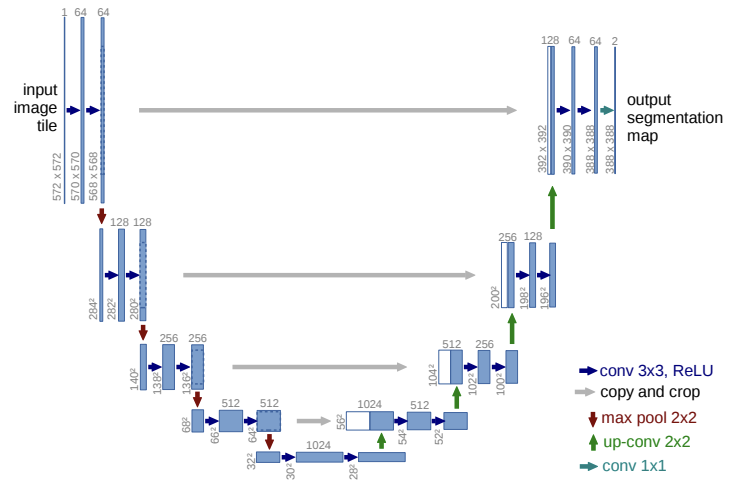  
画像元 (https://arxiv.org/pdf/1505.04597)

また、モデルをGPU上に載せることで、学習や検証の計算速度を大幅に向上させることができます。  
GPUを使用する場合は、以下のようにデバイスを指定します。  

In [18]:
# 使用するGPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの作成 Unet
encoder_name = "resnet18"
# encoder_name = "vgg16"
# encoder_name = "efficientnet-b0"
model = smp.Unet(
    encoder_name=encoder_name,      # バックボーン
    encoder_weights="imagenet",     # 重み
    activation="sigmoid",           # 活性化関数
    in_channels=1,                  # 入力チャンネル数
    classes=1,                      # 出力チャンネル数
)
model = model.to(device)

# ⚖️ 損失関数を定義する

損失関数（Loss Function） とは、正解値（マスク画像）とモデルの予測値との誤差（ずれ）を数値として計算するための関数です。  
この誤差をもとに、モデルは学習を通じてパラメータを調整していきます。  

今回は、DiceLoss（ダイス損失） を使用します。  
DiceLoss は、特にセグメンテーションのようなピクセル単位の分類タスクにおいて効果的な損失関数です。

In [19]:
criterion = smp.losses.DiceLoss(mode='binary', log_loss=False)
# criterion = smp.losses.TverskyLoss(mode='binary', alpha=0.3, beta=0.7)

# 🔧 最適化アルゴリズムを設定する
最適化アルゴリズム（Optimizer） とは、
先ほど説明した 正解値（マスク画像） とモデルの 予測値 との誤差（ロス）を、できるだけ小さくするためのアルゴリズムです。

最適化アルゴリズムは、学習率（Learning Rate） を調整しながら、モデルのパラメータを少しずつ更新し、
最適な解に近づけていく働きをします。

今回は、最適化アルゴリズムとして AdamW を使用します。
AdamW は、精度が高く収束も速いため、画像認識やセグメンテーションでよく使われる手法の一つです。

In [20]:
# 学習率
lr = 0.00001
# optimizerの作成
optimizer = optim.AdamW(model.parameters(), lr=lr)

# 📈 評価指標を定義する
評価指標（Metric） とは、モデルの精度を評価するために使用する指標です。  
例えば、犬と猫の画像を分類するタスクでは、正答率（Accuracy） を使って精度を確認します。

今回は、セグメンテーションタスクでよく用いられているDice係数（Dice Coefficient） を使用して、モデルの性能を評価します。

Dice係数は、**予測結果と正解マスクの重なり具合**を数値化したもので、値が1に近いほど、予測が正解とよく一致していることを意味します。

In [21]:
def dice_coefficient(predicted, target, threshold=0.5):
    # predicted > threshold を 1 に、それ以外を 0 にバイナリ変換
    predicted = (predicted > threshold).float()
    target = (target > threshold).float()

    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum()
    
    dice = (2. * intersection + 1e-6) / (union + 1e-6)  # 1e-6 はゼロ除算を防ぐための小さな値
    return dice

# 🔁 train_epoch 関数と val_epoch 関数を定義する
このセクションでは、モデルの学習と検証を行うための関数であるtrain_epoch 関数と val_epoch 関数を定義します。

- 🏋️‍♂️ train_epoch 関数  

    この関数では、1エポック分の学習を行い、そのエポックにおける 損失（loss） と Dice係数（精度） を計算します。  
    学習時には、モデルを訓練モードに設定する必要があります。  
    その際は、以下のように記述します：
    ```Python
    model.train()
    ```
- 🔍 val_epoch 関数

    この関数では、1エポック分の検証を行い、検証データに対する 損失（loss） と Dice係数（精度） を計算します。  
    検証時には、モデルを検証モードに設定する必要があります。  
    その際は、以下のように記述します：  
    ```Python
    model.eval()
    ```

In [22]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    # lossとdiceの初期化
    train_loss, train_dice = 0.0, 0.0 # このtrain_lossとtrain_diceにlossとdiceを加算していき，最後にデータ数で割ることで平均を計算する

    model.train() # モデルを学習モードに設定
    for images, masks in tqdm(train_loader): # dataloaderからデータを取り出す
        images, masks = images.to(device), masks.to(device) # データをGPUに転送
        optimizer.zero_grad() # 勾配を初期化
        outputs = model(images) # 予測値を計算 # outputs.shape: torch.Size([128, 1, 256, 256])
        outputs = outputs.squeeze(1) # チャンネル次元を削除 # outputs.shape: torch.Size([128, 256, 256])
        loss = criterion(outputs, masks) # 損失を計算
        dice = dice_coefficient(outputs, masks) # diceを計算
        train_loss += loss.item() * images.size(0) # lossを蓄積
        train_dice += dice.item() * images.size(0) # diceを蓄積
        loss.backward() # 逆伝播
        optimizer.step() # パラメータの更新
    avg_train_loss = train_loss / len(train_loader.dataset) # lossの平均を計算
    avg_train_dice = train_dice / len(train_loader.dataset) # diceの平均を計算
    return avg_train_loss, avg_train_dice

def val_epoch(model, val_loader, criterion, device):
    # lossとdiceの初期化
    val_loss, val_dice = 0.0, 0.0

    model.eval() # モデルを評価モードに設定
    with torch.no_grad(): # val_epoch関数では，勾配を計算しない
        for images, masks in tqdm(val_loader): # dataloaderからデータを取り出す
            images, masks = images.to(device), masks.to(device) # データをGPUに転送
            outputs = model(images) # 予測値を計算 # outputs.shape: torch.Size([128, 1, 256, 256])
            outputs = outputs.squeeze(1) # チャンネル次元を削除 # outputs.shape: torch.Size([128, 256, 256])
            loss = criterion(outputs, masks) # 損失を計算
            dice = dice_coefficient(outputs, masks) # diceを計算
            val_loss += loss.item() * images.size(0) # lossを蓄積
            val_dice += dice.item() * images.size(0) # diceを蓄積
    avg_val_loss = val_loss / len(val_loader.dataset) # lossの平均を計算
    avg_val_dice = val_dice / len(val_loader.dataset) # diceの平均を計算
    return avg_val_loss, avg_val_dice

# 🏋️‍♀️ 学習を実行する
モデルを学習する際には、学習用データ全体を何回繰り返して学習するかを示すエポック数（epoch）を設定します。

このエポック数は、モデルの構造やデータの量、ハイパーパラメータの設定などによって適切な値が異なります。

学習は、エポック数に基づいて for 文を使って繰り返し処理を行い、  
各エポックごとにモデルの学習（train_epoch）と検証（val_epoch）を行います。

エポックごとに計算された train_loss、train_dice、val_loss、val_dice はそれぞれリストに保存し、  
後で学習曲線（Lossや精度の推移）を可視化するために使用します。

また、指定したエポック数分の学習が終了したら、学習済みのモデルを保存します。

In [23]:
# エポック数
num_epochs = 200

30分くらいかかります。

In [24]:
# train_loss, train_dice, val_loss, val_diceを保存するリスト
train_loss_list, train_dice_list, val_loss_list, val_dice_list = [], [], [], []

start = time.time()
# 学習
# 0 epoch目はlr = 1で学習したい
for epoch in range(num_epochs):
    # train_epoch関数とval_epoch関数で1エポック分の学習と評価を行う
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = val_epoch(model, val_loader, criterion, device)

    # 各値をリストに追加
    train_loss_list.append(train_loss)
    train_dice_list.append(train_dice)
    val_loss_list.append(val_loss)
    val_dice_list.append(val_dice)

    # ログを出力
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, train_dice: {train_dice:.4f}, val_loss: {val_loss:.4f}, val_dice: {val_dice:.4f}, lr: {optimizer.param_groups[0]['lr']}")

end = time.time()
print(f"経過時間: {end-start:.4f}")

# modelの保存
torch.save(model.state_dict(), f"{encoder_name}_epoch{num_epochs}.pth")

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch: 1, train_loss: 0.9593, train_dice: 0.0354, val_loss: 0.9652, val_dice: 0.0402, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch: 2, train_loss: 0.9580, train_dice: 0.0446, val_loss: 0.9635, val_dice: 0.0533, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch: 3, train_loss: 0.9567, train_dice: 0.0506, val_loss: 0.9624, val_dice: 0.0602, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch: 4, train_loss: 0.9562, train_dice: 0.0553, val_loss: 0.9620, val_dice: 0.0624, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch: 5, train_loss: 0.9557, train_dice: 0.0599, val_loss: 0.9617, val_dice: 0.0667, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch: 6, train_loss: 0.9555, train_dice: 0.0648, val_loss: 0.9614, val_dice: 0.0708, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch: 7, train_loss: 0.9551, train_dice: 0.0709, val_loss: 0.9613, val_dice: 0.0774, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 8, train_loss: 0.9548, train_dice: 0.0778, val_loss: 0.9611, val_dice: 0.0841, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch: 9, train_loss: 0.9547, train_dice: 0.0849, val_loss: 0.9609, val_dice: 0.0923, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch: 10, train_loss: 0.9546, train_dice: 0.0930, val_loss: 0.9607, val_dice: 0.1007, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch: 11, train_loss: 0.9544, train_dice: 0.1013, val_loss: 0.9606, val_dice: 0.1087, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 12, train_loss: 0.9542, train_dice: 0.1094, val_loss: 0.9604, val_dice: 0.1158, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 13, train_loss: 0.9541, train_dice: 0.1179, val_loss: 0.9603, val_dice: 0.1265, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 14, train_loss: 0.9539, train_dice: 0.1272, val_loss: 0.9602, val_dice: 0.1359, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch: 15, train_loss: 0.9538, train_dice: 0.1364, val_loss: 0.9601, val_dice: 0.1466, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 16, train_loss: 0.9536, train_dice: 0.1467, val_loss: 0.9599, val_dice: 0.1566, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 17, train_loss: 0.9535, train_dice: 0.1581, val_loss: 0.9598, val_dice: 0.1667, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch: 18, train_loss: 0.9533, train_dice: 0.1689, val_loss: 0.9597, val_dice: 0.1771, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 19, train_loss: 0.9533, train_dice: 0.1802, val_loss: 0.9597, val_dice: 0.1923, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 20, train_loss: 0.9532, train_dice: 0.1925, val_loss: 0.9595, val_dice: 0.1990, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 21, train_loss: 0.9531, train_dice: 0.2045, val_loss: 0.9595, val_dice: 0.2199, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 22, train_loss: 0.9530, train_dice: 0.2179, val_loss: 0.9595, val_dice: 0.2299, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 23, train_loss: 0.9529, train_dice: 0.2307, val_loss: 0.9594, val_dice: 0.2399, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 24, train_loss: 0.9527, train_dice: 0.2449, val_loss: 0.9593, val_dice: 0.2525, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 25, train_loss: 0.9526, train_dice: 0.2572, val_loss: 0.9592, val_dice: 0.2697, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 26, train_loss: 0.9527, train_dice: 0.2685, val_loss: 0.9592, val_dice: 0.2814, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 27, train_loss: 0.9525, train_dice: 0.2832, val_loss: 0.9592, val_dice: 0.3024, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch: 28, train_loss: 0.9524, train_dice: 0.2965, val_loss: 0.9591, val_dice: 0.3139, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 29, train_loss: 0.9522, train_dice: 0.3079, val_loss: 0.9590, val_dice: 0.3269, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch: 30, train_loss: 0.9522, train_dice: 0.3199, val_loss: 0.9591, val_dice: 0.3374, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 31, train_loss: 0.9522, train_dice: 0.3325, val_loss: 0.9590, val_dice: 0.3506, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch: 32, train_loss: 0.9521, train_dice: 0.3437, val_loss: 0.9590, val_dice: 0.3624, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 33, train_loss: 0.9520, train_dice: 0.3559, val_loss: 0.9588, val_dice: 0.3717, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 34, train_loss: 0.9520, train_dice: 0.3663, val_loss: 0.9588, val_dice: 0.3840, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 35, train_loss: 0.9519, train_dice: 0.3790, val_loss: 0.9588, val_dice: 0.4053, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 36, train_loss: 0.9518, train_dice: 0.3951, val_loss: 0.9586, val_dice: 0.4158, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 37, train_loss: 0.9517, train_dice: 0.4053, val_loss: 0.9587, val_dice: 0.4343, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 38, train_loss: 0.9517, train_dice: 0.4190, val_loss: 0.9586, val_dice: 0.4285, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch: 39, train_loss: 0.9516, train_dice: 0.4318, val_loss: 0.9587, val_dice: 0.4443, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 40, train_loss: 0.9515, train_dice: 0.4413, val_loss: 0.9585, val_dice: 0.4630, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 41, train_loss: 0.9514, train_dice: 0.4527, val_loss: 0.9585, val_dice: 0.4674, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 42, train_loss: 0.9514, train_dice: 0.4619, val_loss: 0.9586, val_dice: 0.4925, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 43, train_loss: 0.9513, train_dice: 0.4696, val_loss: 0.9582, val_dice: 0.4811, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 44, train_loss: 0.9512, train_dice: 0.4819, val_loss: 0.9583, val_dice: 0.5037, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch: 45, train_loss: 0.9511, train_dice: 0.4931, val_loss: 0.9581, val_dice: 0.4954, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 46, train_loss: 0.9512, train_dice: 0.4990, val_loss: 0.9583, val_dice: 0.5280, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 47, train_loss: 0.9511, train_dice: 0.5074, val_loss: 0.9583, val_dice: 0.5251, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 48, train_loss: 0.9510, train_dice: 0.5169, val_loss: 0.9581, val_dice: 0.5126, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch: 49, train_loss: 0.9510, train_dice: 0.5230, val_loss: 0.9583, val_dice: 0.5237, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch: 50, train_loss: 0.9511, train_dice: 0.5264, val_loss: 0.9582, val_dice: 0.5444, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch: 51, train_loss: 0.9508, train_dice: 0.5392, val_loss: 0.9582, val_dice: 0.5619, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 52, train_loss: 0.9508, train_dice: 0.5496, val_loss: 0.9582, val_dice: 0.5682, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch: 53, train_loss: 0.9508, train_dice: 0.5559, val_loss: 0.9581, val_dice: 0.5586, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 54, train_loss: 0.9507, train_dice: 0.5610, val_loss: 0.9582, val_dice: 0.5783, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epoch: 55, train_loss: 0.9508, train_dice: 0.5698, val_loss: 0.9582, val_dice: 0.5929, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch: 56, train_loss: 0.9507, train_dice: 0.5776, val_loss: 0.9579, val_dice: 0.5890, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch: 57, train_loss: 0.9507, train_dice: 0.5813, val_loss: 0.9579, val_dice: 0.5921, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 58, train_loss: 0.9506, train_dice: 0.5915, val_loss: 0.9579, val_dice: 0.5959, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch: 59, train_loss: 0.9506, train_dice: 0.5938, val_loss: 0.9579, val_dice: 0.6081, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch: 60, train_loss: 0.9505, train_dice: 0.6028, val_loss: 0.9578, val_dice: 0.6023, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 61, train_loss: 0.9505, train_dice: 0.6058, val_loss: 0.9579, val_dice: 0.6125, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 62, train_loss: 0.9504, train_dice: 0.6083, val_loss: 0.9578, val_dice: 0.6243, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 63, train_loss: 0.9503, train_dice: 0.6180, val_loss: 0.9577, val_dice: 0.6156, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch: 64, train_loss: 0.9504, train_dice: 0.6187, val_loss: 0.9578, val_dice: 0.6347, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 65, train_loss: 0.9504, train_dice: 0.6247, val_loss: 0.9577, val_dice: 0.6147, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch: 66, train_loss: 0.9503, train_dice: 0.6321, val_loss: 0.9577, val_dice: 0.6344, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 67, train_loss: 0.9502, train_dice: 0.6329, val_loss: 0.9577, val_dice: 0.6414, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch: 68, train_loss: 0.9502, train_dice: 0.6389, val_loss: 0.9578, val_dice: 0.6361, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 69, train_loss: 0.9501, train_dice: 0.6443, val_loss: 0.9576, val_dice: 0.6428, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 70, train_loss: 0.9503, train_dice: 0.6395, val_loss: 0.9579, val_dice: 0.6568, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 71, train_loss: 0.9502, train_dice: 0.6497, val_loss: 0.9576, val_dice: 0.6481, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch: 72, train_loss: 0.9501, train_dice: 0.6528, val_loss: 0.9575, val_dice: 0.6425, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch: 73, train_loss: 0.9502, train_dice: 0.6555, val_loss: 0.9575, val_dice: 0.6476, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch: 74, train_loss: 0.9502, train_dice: 0.6446, val_loss: 0.9578, val_dice: 0.6635, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch: 75, train_loss: 0.9500, train_dice: 0.6586, val_loss: 0.9576, val_dice: 0.6699, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 76, train_loss: 0.9500, train_dice: 0.6625, val_loss: 0.9574, val_dice: 0.6497, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 77, train_loss: 0.9499, train_dice: 0.6659, val_loss: 0.9576, val_dice: 0.6677, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch: 78, train_loss: 0.9499, train_dice: 0.6640, val_loss: 0.9576, val_dice: 0.6722, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 79, train_loss: 0.9499, train_dice: 0.6619, val_loss: 0.9574, val_dice: 0.6618, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch: 80, train_loss: 0.9498, train_dice: 0.6665, val_loss: 0.9574, val_dice: 0.6667, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 81, train_loss: 0.9499, train_dice: 0.6740, val_loss: 0.9574, val_dice: 0.6656, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch: 82, train_loss: 0.9499, train_dice: 0.6699, val_loss: 0.9574, val_dice: 0.6576, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 83, train_loss: 0.9499, train_dice: 0.6741, val_loss: 0.9577, val_dice: 0.6810, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 84, train_loss: 0.9498, train_dice: 0.6707, val_loss: 0.9574, val_dice: 0.6723, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 85, train_loss: 0.9498, train_dice: 0.6790, val_loss: 0.9573, val_dice: 0.6749, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 86, train_loss: 0.9497, train_dice: 0.6827, val_loss: 0.9573, val_dice: 0.6739, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch: 87, train_loss: 0.9497, train_dice: 0.6885, val_loss: 0.9570, val_dice: 0.6520, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 88, train_loss: 0.9497, train_dice: 0.6869, val_loss: 0.9572, val_dice: 0.6702, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 89, train_loss: 0.9497, train_dice: 0.6868, val_loss: 0.9576, val_dice: 0.6953, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch: 90, train_loss: 0.9497, train_dice: 0.6930, val_loss: 0.9575, val_dice: 0.7056, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch: 91, train_loss: 0.9497, train_dice: 0.6986, val_loss: 0.9572, val_dice: 0.6861, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 92, train_loss: 0.9497, train_dice: 0.6986, val_loss: 0.9573, val_dice: 0.6939, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 93, train_loss: 0.9497, train_dice: 0.6946, val_loss: 0.9576, val_dice: 0.7093, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 94, train_loss: 0.9495, train_dice: 0.7059, val_loss: 0.9575, val_dice: 0.7088, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch: 95, train_loss: 0.9495, train_dice: 0.7062, val_loss: 0.9565, val_dice: 0.6547, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 96, train_loss: 0.9495, train_dice: 0.6955, val_loss: 0.9574, val_dice: 0.7038, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 97, train_loss: 0.9495, train_dice: 0.7106, val_loss: 0.9572, val_dice: 0.7018, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 98, train_loss: 0.9497, train_dice: 0.7145, val_loss: 0.9574, val_dice: 0.7092, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch: 99, train_loss: 0.9496, train_dice: 0.7151, val_loss: 0.9570, val_dice: 0.7028, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 100, train_loss: 0.9494, train_dice: 0.7190, val_loss: 0.9569, val_dice: 0.6904, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 101, train_loss: 0.9495, train_dice: 0.7196, val_loss: 0.9569, val_dice: 0.6981, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch: 102, train_loss: 0.9494, train_dice: 0.7186, val_loss: 0.9569, val_dice: 0.6947, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch: 103, train_loss: 0.9494, train_dice: 0.7264, val_loss: 0.9570, val_dice: 0.7048, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch: 104, train_loss: 0.9493, train_dice: 0.7214, val_loss: 0.9569, val_dice: 0.7026, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch: 105, train_loss: 0.9493, train_dice: 0.7224, val_loss: 0.9569, val_dice: 0.7063, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 106, train_loss: 0.9493, train_dice: 0.7261, val_loss: 0.9564, val_dice: 0.6778, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 107, train_loss: 0.9494, train_dice: 0.7151, val_loss: 0.9568, val_dice: 0.7014, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 108, train_loss: 0.9493, train_dice: 0.7233, val_loss: 0.9571, val_dice: 0.7177, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 109, train_loss: 0.9493, train_dice: 0.7295, val_loss: 0.9568, val_dice: 0.7020, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 110, train_loss: 0.9494, train_dice: 0.7268, val_loss: 0.9570, val_dice: 0.7149, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch: 111, train_loss: 0.9493, train_dice: 0.7329, val_loss: 0.9568, val_dice: 0.7146, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 112, train_loss: 0.9492, train_dice: 0.7306, val_loss: 0.9569, val_dice: 0.7169, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 113, train_loss: 0.9492, train_dice: 0.7348, val_loss: 0.9570, val_dice: 0.7134, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 114, train_loss: 0.9491, train_dice: 0.7359, val_loss: 0.9568, val_dice: 0.7062, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch: 115, train_loss: 0.9492, train_dice: 0.7400, val_loss: 0.9570, val_dice: 0.7144, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 116, train_loss: 0.9490, train_dice: 0.7399, val_loss: 0.9568, val_dice: 0.7158, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch: 117, train_loss: 0.9492, train_dice: 0.7361, val_loss: 0.9567, val_dice: 0.7058, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch: 118, train_loss: 0.9491, train_dice: 0.7311, val_loss: 0.9566, val_dice: 0.7106, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 119, train_loss: 0.9492, train_dice: 0.7407, val_loss: 0.9567, val_dice: 0.7135, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 120, train_loss: 0.9492, train_dice: 0.7420, val_loss: 0.9566, val_dice: 0.7143, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch: 121, train_loss: 0.9490, train_dice: 0.7459, val_loss: 0.9565, val_dice: 0.7059, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 122, train_loss: 0.9490, train_dice: 0.7416, val_loss: 0.9565, val_dice: 0.7186, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 123, train_loss: 0.9491, train_dice: 0.7430, val_loss: 0.9568, val_dice: 0.7212, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch: 124, train_loss: 0.9489, train_dice: 0.7482, val_loss: 0.9566, val_dice: 0.7243, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 125, train_loss: 0.9490, train_dice: 0.7438, val_loss: 0.9566, val_dice: 0.7164, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 126, train_loss: 0.9490, train_dice: 0.7494, val_loss: 0.9565, val_dice: 0.7204, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch: 127, train_loss: 0.9490, train_dice: 0.7434, val_loss: 0.9568, val_dice: 0.7290, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 128, train_loss: 0.9490, train_dice: 0.7480, val_loss: 0.9565, val_dice: 0.7227, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 129, train_loss: 0.9489, train_dice: 0.7527, val_loss: 0.9568, val_dice: 0.7247, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 130, train_loss: 0.9488, train_dice: 0.7600, val_loss: 0.9564, val_dice: 0.7215, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch: 131, train_loss: 0.9490, train_dice: 0.7429, val_loss: 0.9568, val_dice: 0.7341, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch: 132, train_loss: 0.9489, train_dice: 0.7532, val_loss: 0.9569, val_dice: 0.7308, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch: 133, train_loss: 0.9488, train_dice: 0.7595, val_loss: 0.9569, val_dice: 0.7312, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch: 134, train_loss: 0.9488, train_dice: 0.7575, val_loss: 0.9565, val_dice: 0.7304, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 135, train_loss: 0.9489, train_dice: 0.7656, val_loss: 0.9564, val_dice: 0.7200, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 136, train_loss: 0.9489, train_dice: 0.7527, val_loss: 0.9562, val_dice: 0.7146, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch: 137, train_loss: 0.9487, train_dice: 0.7571, val_loss: 0.9564, val_dice: 0.7286, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch: 138, train_loss: 0.9488, train_dice: 0.7574, val_loss: 0.9565, val_dice: 0.7342, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 139, train_loss: 0.9487, train_dice: 0.7678, val_loss: 0.9566, val_dice: 0.7349, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 140, train_loss: 0.9488, train_dice: 0.7689, val_loss: 0.9570, val_dice: 0.7389, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 141, train_loss: 0.9487, train_dice: 0.7711, val_loss: 0.9568, val_dice: 0.7386, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 142, train_loss: 0.9486, train_dice: 0.7715, val_loss: 0.9565, val_dice: 0.7281, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 143, train_loss: 0.9488, train_dice: 0.7624, val_loss: 0.9564, val_dice: 0.7340, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 144, train_loss: 0.9488, train_dice: 0.7690, val_loss: 0.9567, val_dice: 0.7393, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 145, train_loss: 0.9485, train_dice: 0.7686, val_loss: 0.9569, val_dice: 0.7447, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch: 146, train_loss: 0.9486, train_dice: 0.7752, val_loss: 0.9567, val_dice: 0.7389, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch: 147, train_loss: 0.9485, train_dice: 0.7740, val_loss: 0.9568, val_dice: 0.7441, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 148, train_loss: 0.9486, train_dice: 0.7746, val_loss: 0.9567, val_dice: 0.7435, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch: 149, train_loss: 0.9485, train_dice: 0.7723, val_loss: 0.9565, val_dice: 0.7375, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 150, train_loss: 0.9486, train_dice: 0.7763, val_loss: 0.9568, val_dice: 0.7420, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 151, train_loss: 0.9486, train_dice: 0.7780, val_loss: 0.9567, val_dice: 0.7387, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 152, train_loss: 0.9485, train_dice: 0.7779, val_loss: 0.9564, val_dice: 0.7371, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 153, train_loss: 0.9487, train_dice: 0.7810, val_loss: 0.9566, val_dice: 0.7402, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 154, train_loss: 0.9487, train_dice: 0.7772, val_loss: 0.9561, val_dice: 0.7354, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 155, train_loss: 0.9486, train_dice: 0.7795, val_loss: 0.9565, val_dice: 0.7385, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 156, train_loss: 0.9485, train_dice: 0.7846, val_loss: 0.9563, val_dice: 0.7415, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch: 157, train_loss: 0.9484, train_dice: 0.7790, val_loss: 0.9567, val_dice: 0.7494, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch: 158, train_loss: 0.9487, train_dice: 0.7856, val_loss: 0.9566, val_dice: 0.7468, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch: 159, train_loss: 0.9486, train_dice: 0.7884, val_loss: 0.9561, val_dice: 0.7362, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 160, train_loss: 0.9484, train_dice: 0.7812, val_loss: 0.9565, val_dice: 0.7449, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 161, train_loss: 0.9484, train_dice: 0.7870, val_loss: 0.9564, val_dice: 0.7435, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch: 162, train_loss: 0.9484, train_dice: 0.7891, val_loss: 0.9564, val_dice: 0.7438, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 163, train_loss: 0.9484, train_dice: 0.7946, val_loss: 0.9563, val_dice: 0.7434, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 164, train_loss: 0.9484, train_dice: 0.7931, val_loss: 0.9565, val_dice: 0.7458, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch: 165, train_loss: 0.9484, train_dice: 0.7829, val_loss: 0.9562, val_dice: 0.7499, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 166, train_loss: 0.9484, train_dice: 0.7827, val_loss: 0.9559, val_dice: 0.7359, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 167, train_loss: 0.9483, train_dice: 0.7797, val_loss: 0.9562, val_dice: 0.7364, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 168, train_loss: 0.9483, train_dice: 0.7863, val_loss: 0.9562, val_dice: 0.7427, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 169, train_loss: 0.9485, train_dice: 0.7872, val_loss: 0.9565, val_dice: 0.7470, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 170, train_loss: 0.9483, train_dice: 0.7934, val_loss: 0.9564, val_dice: 0.7436, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 171, train_loss: 0.9483, train_dice: 0.7950, val_loss: 0.9563, val_dice: 0.7452, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 172, train_loss: 0.9482, train_dice: 0.7915, val_loss: 0.9565, val_dice: 0.7479, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch: 173, train_loss: 0.9484, train_dice: 0.7961, val_loss: 0.9565, val_dice: 0.7483, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch: 174, train_loss: 0.9482, train_dice: 0.7984, val_loss: 0.9564, val_dice: 0.7492, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch: 175, train_loss: 0.9481, train_dice: 0.8013, val_loss: 0.9563, val_dice: 0.7474, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


Epoch: 176, train_loss: 0.9482, train_dice: 0.8021, val_loss: 0.9563, val_dice: 0.7446, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 177, train_loss: 0.9482, train_dice: 0.7932, val_loss: 0.9562, val_dice: 0.7466, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch: 178, train_loss: 0.9482, train_dice: 0.7998, val_loss: 0.9559, val_dice: 0.7426, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 179, train_loss: 0.9483, train_dice: 0.8026, val_loss: 0.9563, val_dice: 0.7522, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch: 180, train_loss: 0.9482, train_dice: 0.8032, val_loss: 0.9563, val_dice: 0.7523, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch: 181, train_loss: 0.9481, train_dice: 0.7977, val_loss: 0.9569, val_dice: 0.7505, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch: 182, train_loss: 0.9481, train_dice: 0.8007, val_loss: 0.9567, val_dice: 0.7522, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 183, train_loss: 0.9482, train_dice: 0.8026, val_loss: 0.9559, val_dice: 0.7465, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 184, train_loss: 0.9482, train_dice: 0.8017, val_loss: 0.9560, val_dice: 0.7427, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 185, train_loss: 0.9482, train_dice: 0.7992, val_loss: 0.9561, val_dice: 0.7457, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch: 186, train_loss: 0.9482, train_dice: 0.7997, val_loss: 0.9564, val_dice: 0.7548, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch: 187, train_loss: 0.9482, train_dice: 0.8081, val_loss: 0.9557, val_dice: 0.7433, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 188, train_loss: 0.9481, train_dice: 0.8014, val_loss: 0.9564, val_dice: 0.7542, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch: 189, train_loss: 0.9481, train_dice: 0.7964, val_loss: 0.9563, val_dice: 0.7558, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epoch: 190, train_loss: 0.9484, train_dice: 0.8046, val_loss: 0.9558, val_dice: 0.7479, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch: 191, train_loss: 0.9482, train_dice: 0.7869, val_loss: 0.9564, val_dice: 0.7546, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch: 192, train_loss: 0.9481, train_dice: 0.8051, val_loss: 0.9563, val_dice: 0.7548, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch: 193, train_loss: 0.9481, train_dice: 0.8070, val_loss: 0.9563, val_dice: 0.7581, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch: 194, train_loss: 0.9480, train_dice: 0.8055, val_loss: 0.9561, val_dice: 0.7525, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch: 195, train_loss: 0.9481, train_dice: 0.8031, val_loss: 0.9561, val_dice: 0.7508, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 196, train_loss: 0.9481, train_dice: 0.8107, val_loss: 0.9557, val_dice: 0.7434, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 197, train_loss: 0.9480, train_dice: 0.8084, val_loss: 0.9560, val_dice: 0.7546, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch: 198, train_loss: 0.9481, train_dice: 0.8119, val_loss: 0.9561, val_dice: 0.7543, lr: 1e-05


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch: 199, train_loss: 0.9481, train_dice: 0.8112, val_loss: 0.9560, val_dice: 0.7555, lr: 1e-05


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch: 200, train_loss: 0.9480, train_dice: 0.8138, val_loss: 0.9561, val_dice: 0.7581, lr: 1e-05
経過時間: 1905.0104


# 📊 Dice係数とLoss（誤差）を表示する

学習の過程で記録した Dice係数（精度） と Loss（損失） を表示します。  
これにより、モデルがどのように学習・検証されていったのかを視覚的に確認することができます。

In [25]:
print(f"train_loss : {train_loss_list[-1]:.4f}")
print(f"train_dice : {train_dice_list[-1]:.4f}")
print(f"val_loss   : {val_loss_list[-1]:.4f}")
print(f"val_dice   : {val_dice_list[-1]:.4f}")

train_loss : 0.9480
train_dice : 0.8138
val_loss   : 0.9561
val_dice   : 0.7581


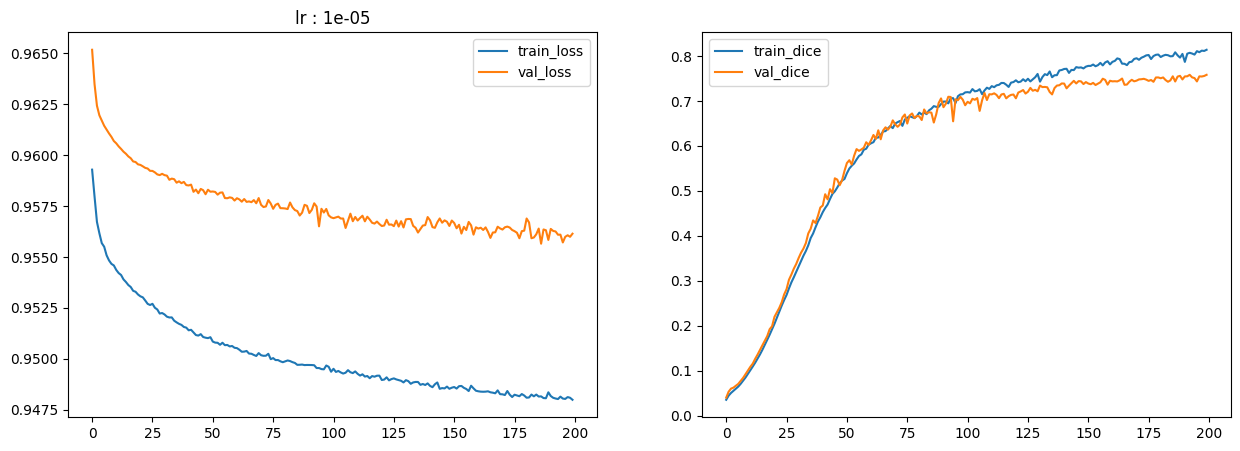

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.title(f"lr : {lr}")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_dice_list, label="train_dice")
plt.plot(val_dice_list, label="val_dice")
plt.legend()
plt.show()

# 🧪 テスト用データに対する精度の確認
学習用データと検証用データを用いて学習したモデルを保存済みファイルからロードし、テスト用データに対する精度を検証します。

モデルをロードする際には、以下の手順で行います：

1. モデルの構造を再度定義する
2. 保存されたパラメータ（重み）を読み込む

In [27]:
# モデル
encoder_name = "resnet18"
model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=None,
    activation="sigmoid",
    in_channels=1,
    classes=1,
)

# モデルの重みを読み込む
model.load_state_dict(torch.load(f"{encoder_name}_epoch{num_epochs}.pth"))
model = model.to(device)

学習済みモデルを用いて、テスト用データに対する最終的な精度（Dice係数）を評価します。  
検証には、先ほど定義した val_epoch 関数を使用します。  
この評価により、モデルが未知のデータに対してどれだけ正確にマスクを予測できるかを確認することができます。  

In [28]:
_, test_dice = val_epoch(model, test_loader, criterion, device)
print(f"test_dice: {test_dice:.4f}")

100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

test_dice: 0.6220


# 🖼️ テスト用データに対する予測結果を可視化する

テスト用データに対してモデルが行った予測結果を可視化します。  
これにより、モデルが実際にどのようにマスク画像を生成しているかを視覚的に確認することができます。

可視化では、元の画像・正解マスク・予測マスクを並べて表示することで、モデルの性能を直感的に理解しやすくなります。

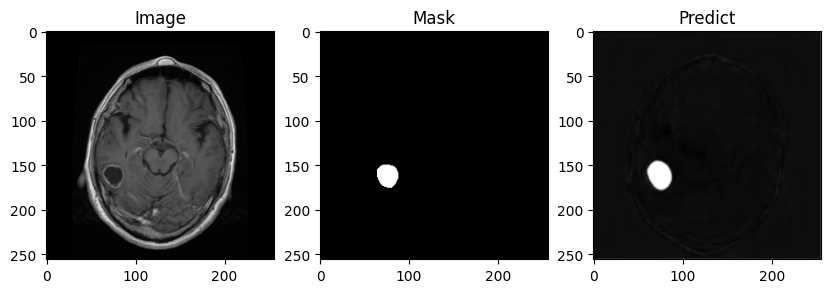

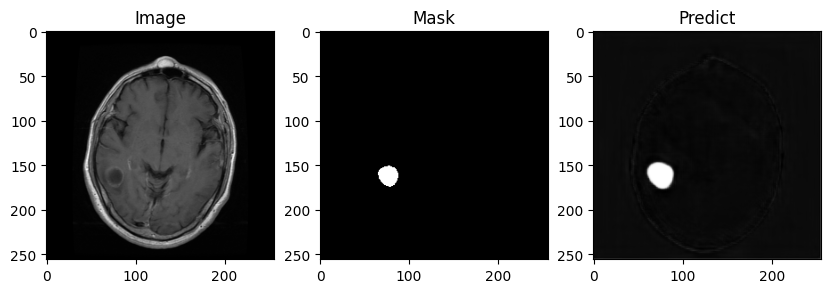

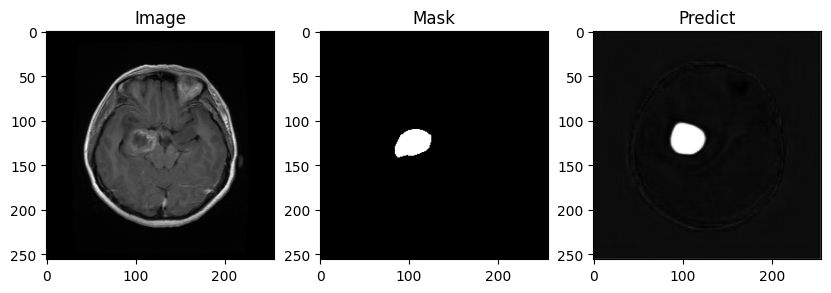

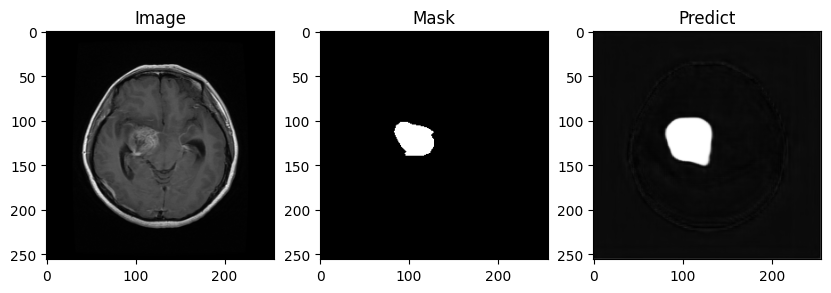

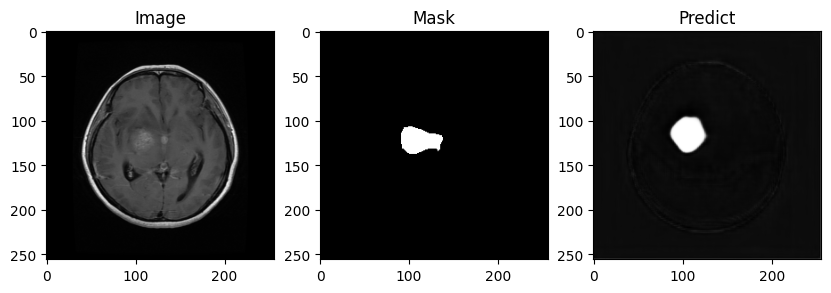

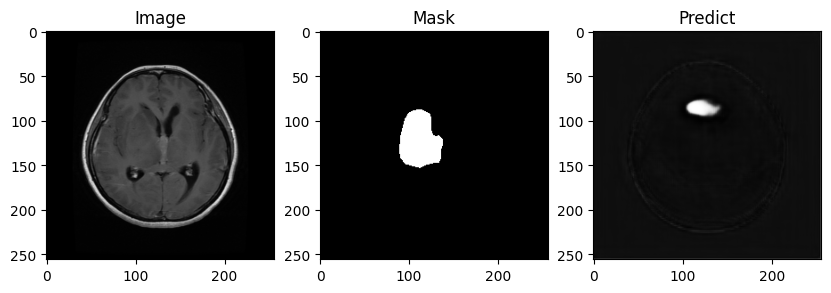

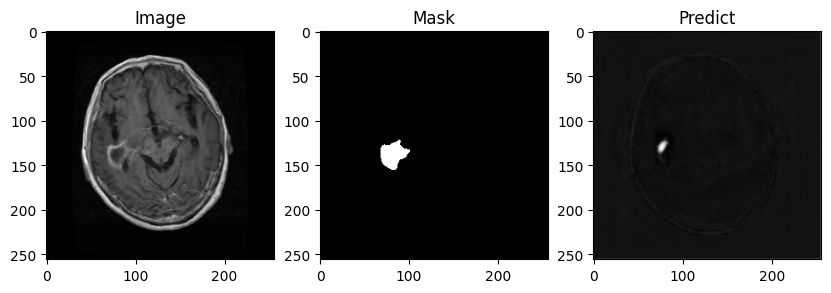

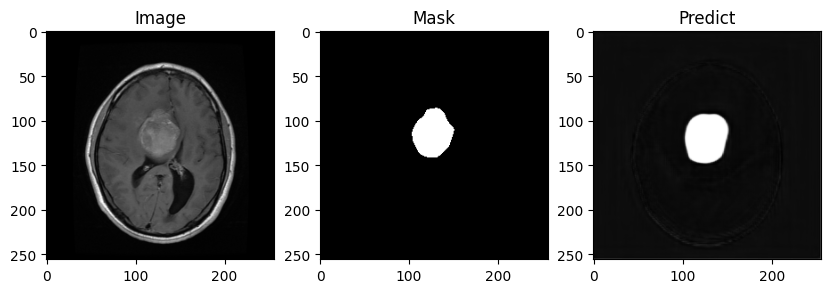

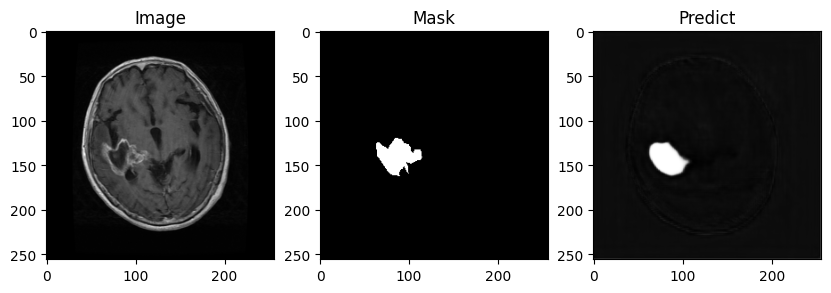

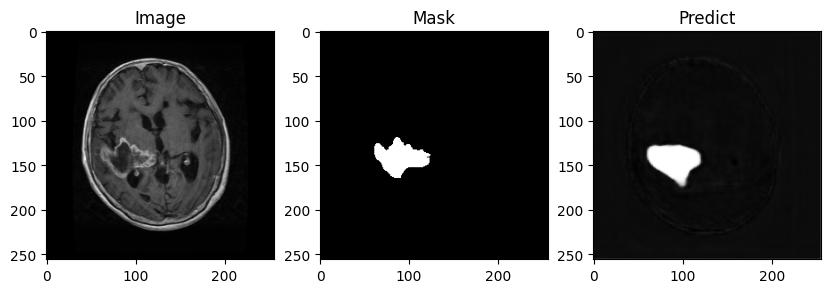

In [29]:
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = outputs.squeeze(1)
        break

for i in range(10): # 10枚分の画像を表示
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1)
    plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Image")
    plt.subplot(1,3,2)
    plt.imshow(masks[i].cpu().numpy(), cmap='gray')
    plt.title("Mask")
    plt.subplot(1,3,3)
    plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
    plt.title("Predict")
    plt.show()